## __Optimizing Customer Segmentation with PCA and Clustering Methods__

## Introduction
In today's competitive business environment, effectively segmenting customers is essential for tailoring marketing strategies and enhancing operational efficiency. The ability to accurately classify customers based on their purchasing behavior can significantly impact a business's ability to target and serve its clientele effectively.

This project aims to analyze the Wholesale Customers Dataset to identify distinct customer segments. To achieve this, we employ Principal Component Analysis (PCA) combined with various clustering techniques.

__Principal Component Analysis (PCA)__ is a dimensionality reduction technique that simplifies high-dimensional data by transforming it into a new coordinate system where the most significant variances are captured in the first few components. This reduction helps in distilling complex data into more interpretable forms, improving the effectiveness and efficiency of subsequent clustering analysis.

We apply the following clustering methods to the reduced dataset:

__K-Means Clustering:__ A widely-used method that partitions data into k clusters by iteratively assigning data points to the nearest cluster centroid and updating centroids to minimize within-cluster variance.<br>  

__BIRCH__ (Balanced Iterative Reducing and Clustering using Hierarchies): An efficient clustering method that incrementally builds a clustering feature tree to handle large datasets, identifying clusters based on hierarchical structures and density.<br>  

__Agglomerative Hierarchical Clustering:__ This method builds a hierarchy of clusters through an iterative process of merging smaller clusters into larger ones (agglomerative), which can be visualized with a dendrogram to determine the optimal number of clusters.<br>  

__Spectral Clustering:__ A technique that uses eigenvalues of similarity matrices to perform dimensionality reduction before applying clustering algorithms. It is particularly effective for identifying clusters with complex shapes.

The objectives of this analysis are:
- To uncover distinct customer segments and patterns in purchasing behavior using a range of clustering methods.
- To optimize the clustering process by reducing dimensionality with PCA, enhancing the performance and interpretability of each clustering technique.

In [83]:
# Importing all libraries
import pandas as pd, numpy as np
import seaborn as sb, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Data Preparation

### 1. Loading the Dataset
First, we will import the dataset using Pandas library.

In [6]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df = pd.read_csv(url)
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [9]:
# Dropping categorical columns (Channel and Region)
X = df.drop(columns=['Channel', 'Region'])

In [11]:
print(f'Missing Values: {X.isnull().sum().sum()}')

Missing Values: 0


### 2. Preprocessing the Data
Before applying Principal Component Analysis (PCA), it's crucial to preprocess the data properly. Since the columns in the dataset may have different scales, scaling the data is necessary to ensure that PCA performs optimally.

In [13]:
scale = StandardScaler()
X_scale = scale.fit_transform(X)
X_scale

array([[ 0.05293319,  0.52356777, -0.04111489, -0.58936716, -0.04356873,
        -0.06633906],
       [-0.39130197,  0.54445767,  0.17031835, -0.27013618,  0.08640684,
         0.08915105],
       [-0.44702926,  0.40853771, -0.0281571 , -0.13753572,  0.13323164,
         2.24329255],
       ...,
       [ 0.20032554,  1.31467078,  2.34838631, -0.54337975,  2.51121768,
         0.12145607],
       [-0.13538389, -0.51753572, -0.60251388, -0.41944059, -0.56977032,
         0.21304614],
       [-0.72930698, -0.5559243 , -0.57322717, -0.62009417, -0.50488752,
        -0.52286938]])

### 3. Applying PCA
Next, we will apply Principal Component Analysis (PCA) to the scaled data to reduce its dimensionality. Specifically, we will transform the dataset into two principal components to simplify the data while retaining its essential features.

In [30]:
pca = PCA(n_components=2)
pca_data_reduced = pca.fit_transform(X_scale)
pca_data_reduced.shape

(440, 2)

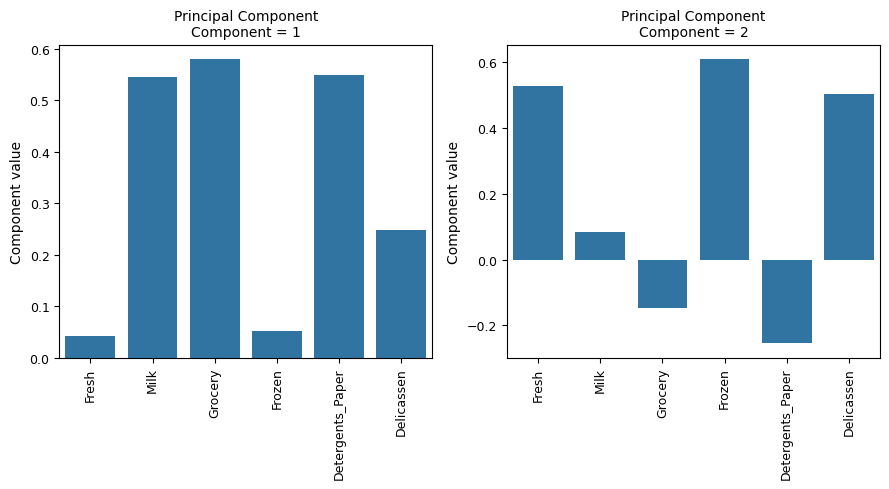

In [63]:
# Accessing principal components
principle_component = pca.components_
pc_df = pd.DataFrame(principle_component, columns=X.columns)
# Visualizing each component
fig, axs = plt.subplots(1, 2, figsize=(9, 5), layout='tight')
for comp in [0, 1]:
    sb.barplot(pc_df.loc[comp], ax=axs[comp])
    axs[comp].set_ylabel('Component value', size=10)
    axs[comp].tick_params(axis='x', rotation=90, labelsize=9)
    axs[comp].tick_params(axis='y', labelsize=9)
    axs[comp].set_title(f'Principal Component\nComponent = {comp+1}', size=10, fontweight='medium')
    

The first Principal Component is a linear combination of the features and Milk, Grocery and Detergents_Paper provided significant contributions to it so it indicates that these features have a strong influence on the direction of maximum variance in the dataset. For the second Principal Component, Fresh, Frozen and Delicassen gave a strong contribution.

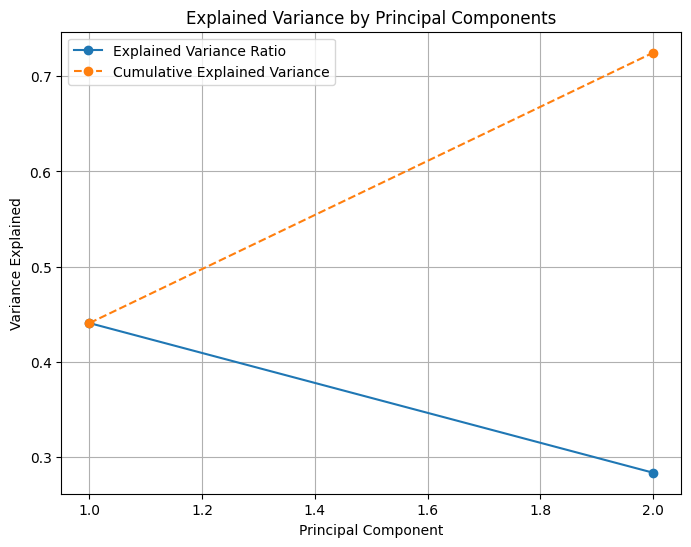

In [67]:
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()
# Visualize the variance captured by each component
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', 
         label='Explained Variance Ratio')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_explained_variance, marker='o', 
         linestyle='--', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid()
plt.show()

The cumulative explained variance for the first two components is 0.73, which means these two components together explain about 73% of the variance in your dataset.

## Clustering Implementation and Evaluation
In this section, we apply various clustering methods to the dimensionally reduced data. We will begin by determining the optimal number of clusters for each method, then compare the performance of the clustering algorithms. Ultimately, we will select the best clustering approach based on the evaluation metrics.

In [119]:
def plot_func(df, cluster_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout='tight', dpi=90)
    
    axs[0].plot(df['n_clusters'], df['silhouette'], marker='o', ms=4, lw=1, label='silhouette score')
    axs[0].set_title(f'{cluster_name} - Silhouette Score')
    axs[0].set_xlabel('Number of clusters')
    axs[0].set_ylabel('Silhouette score')
    
    axs[1].plot(km_df['n_clusters'], km_df['davies_bouldin'], marker='o', ms=4, lw=1, linestyle='--', color='orange', label='davies bouldin score')
    axs[1].set_title(f'{cluster_name} - Davies Bouldin Score')
    axs[1].set_xlabel('Number of clusters')
    axs[1].set_ylabel('Davies bouldin score')
    plt.show()


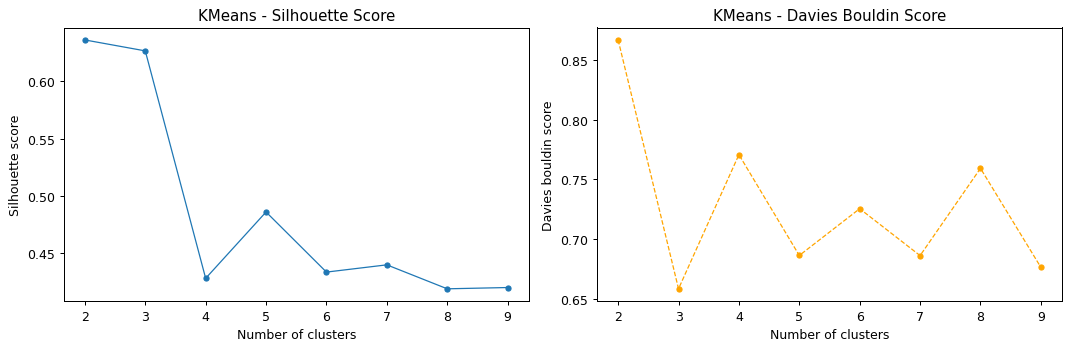

In [128]:
# KMeans clustering
km_result = {'n_clusters':[], 'silhouette':[], 'davies_bouldin':[]}
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=234)
    X_pred = km.fit_predict(pca_data_reduced)
    sh = silhouette_score(pca_data_reduced, X_pred)
    db = davies_bouldin_score(pca_data_reduced, X_pred)
    km_result['n_clusters'].append(k)
    km_result['silhouette'].append(sh)
    km_result['davies_bouldin'].append(db)

km_df = pd.DataFrame(km_result)
plot_func(km_df, 'KMeans')

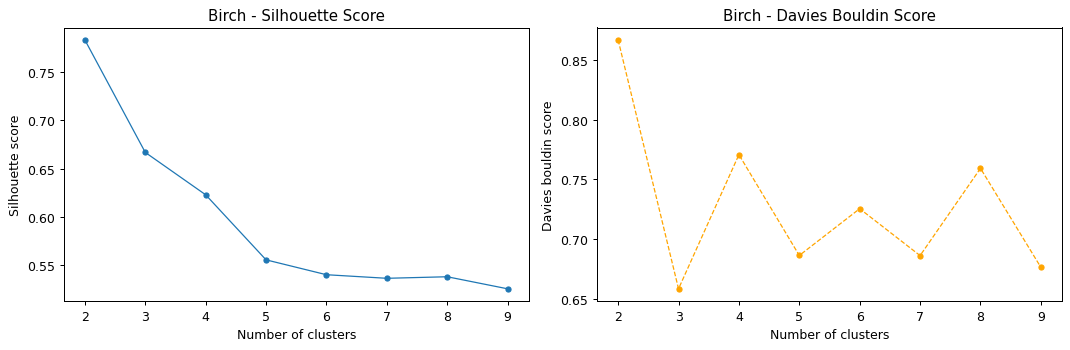

In [127]:
# Birch clustering
result = {'n_clusters':[], 'silhouette':[], 'davies_bouldin':[]}
for k in range(2, 10):
    br = Birch(n_clusters=k)
    X_pred = br.fit_predict(pca_data_reduced)
    sh = silhouette_score(pca_data_reduced, X_pred)
    db = davies_bouldin_score(pca_data_reduced, X_pred)
    result['n_clusters'].append(k)
    result['silhouette'].append(sh)
    result['davies_bouldin'].append(db)

br_df = pd.DataFrame(result)
plot_func(br_df, 'Birch')

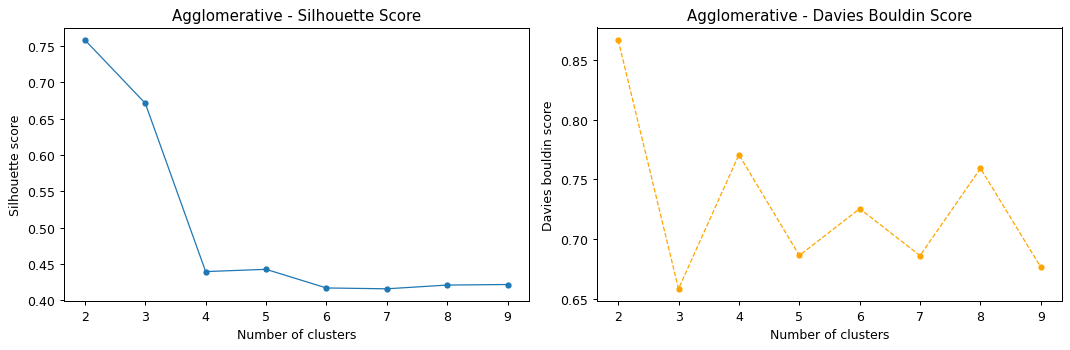

In [133]:
# Agglomerative clustering
result = {'n_clusters':[], 'silhouette':[], 'davies_bouldin':[]}
for k in range(2, 10):
    ac = AgglomerativeClustering(n_clusters=k)
    X_pred = ac.fit_predict(pca_data_reduced)
    sh = silhouette_score(pca_data_reduced, X_pred)
    db = davies_bouldin_score(pca_data_reduced, X_pred)
    result['n_clusters'].append(k)
    result['silhouette'].append(sh)
    result['davies_bouldin'].append(db)

ac_df = pd.DataFrame(result)
plot_func(ac_df, 'Agglomerative')

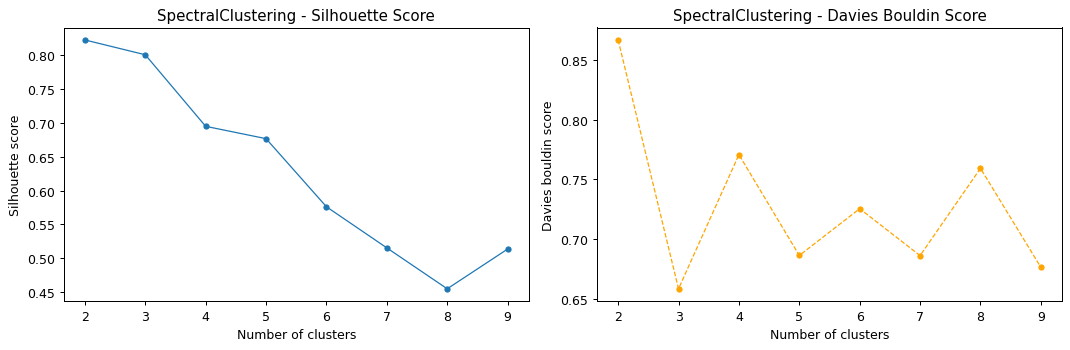

In [134]:
# Spectral clustering
result = {'n_clusters':[], 'silhouette':[], 'davies_bouldin':[]}
for k in range(2, 10):
    sc = SpectralClustering(n_clusters=k)
    X_pred = sc.fit_predict(pca_data_reduced)
    sh = silhouette_score(pca_data_reduced, X_pred)
    db = davies_bouldin_score(pca_data_reduced, X_pred)
    result['n_clusters'].append(k)
    result['silhouette'].append(sh)
    result['davies_bouldin'].append(db)

sc_df = pd.DataFrame(result)
plot_func(sc_df, 'SpectralClustering')

After implementing several clustering algorithms on the dimensionally reduced dataset, including `KMeans`, `Birch`, `AgglomerativeClustering`, and `SpectralClustering`, the results indicated that 3 clusters provided the most suitable structure for the data. Each method was evaluated using different metrics, such as the `silhouette score` and `Davies-Bouldin index`, to ensure that the clusters were well-defined and distinct. Despite differences in the clustering approaches, all methods consistently converged on 3 clusters as the optimal configuration, suggesting a strong natural grouping within the dataset. For further analysis, I will proceed with KMeans.

## Visualizing the Clusters
I will proceed to visualize the clusters using a scatter plot based on the first two principal components obtained from PCA. Each of the 3 clusters will be represented with different colors to clearly distinguish them. This visualization will help us understand the distribution of the data points within each cluster and assess the effectiveness of the clustering method. Additionally, I will highlight the centroids of each cluster to indicate their central locations.

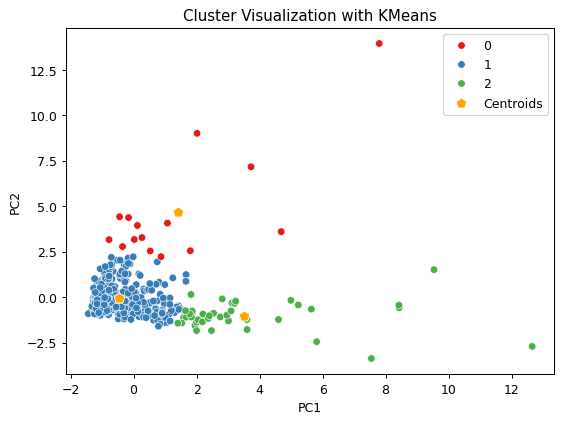

In [169]:
km = KMeans(n_clusters=3)
labels = km.fit_predict(pca_data_reduced)
center_points = km.cluster_centers_

plt.figure(figsize=(7, 5), dpi=90)
sb.scatterplot(x=pca_data_reduced[:, 0], y=pca_data_reduced[:, 1], hue=labels, palette='Set1', legend='full')
sb.scatterplot(x=center_points[:, 0], y=center_points[:, 1], color='orange', marker='p', s=80, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Cluster Visualization with KMeans')
plt.legend()
plt.show()

## Analyzing Cluster Characteristics
In this section, I will calculate the average spending for each category based on the identified clusters. This involves aggregating the spending data to determine how much each cluster typically spends on different product categories, such as Fresh, Milk, Grocery, Frozen, Detergents_Paper, and Delicassen.

Once the average spending for each cluster is calculated, I will summarize the findings to highlight the key characteristics that define each cluster. This analysis will provide insights into customer behavior and preferences, allowing for a better understanding of the different segments within the dataset.

In [173]:
# Adding cluster to data
X['clusters'] = labels
X.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,clusters
0,12669,9656,7561,214,2674,1338,1
1,7057,9810,9568,1762,3293,1776,1
2,6353,8808,7684,2405,3516,7844,1
3,13265,1196,4221,6404,507,1788,1
4,22615,5410,7198,3915,1777,5185,1


In [175]:
summary = X.groupby('clusters').mean().reset_index()
summary

,clusters,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,45720.600000,12574.533333,10878.666667,18173.733333,1463.600000,8563.200000
1,1,11159.696335,4071.727749,5460.798429,2624.036649,1715.803665,1206.096859
2,2,7705.069767,18752.069767,29054.813953,1782.837209,13731.767442,1901.534884


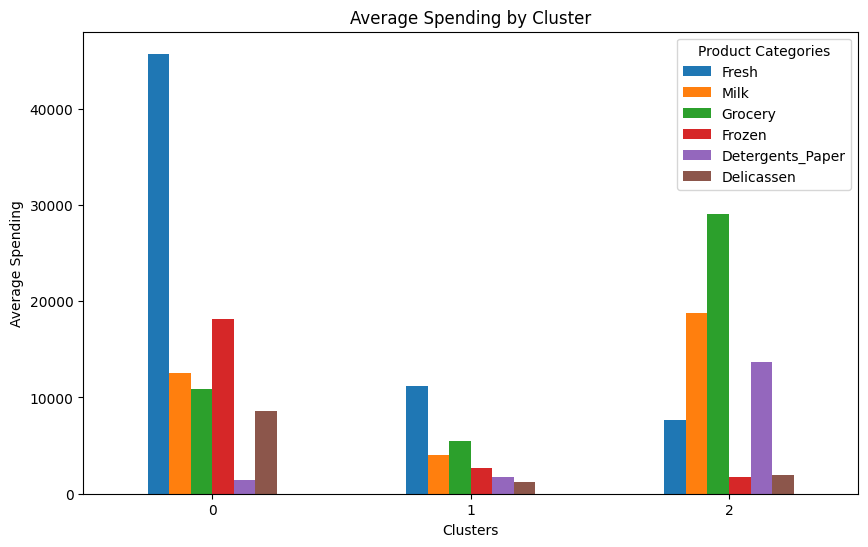

In [179]:
summary.set_index('clusters').plot(kind='bar', figsize=(10, 6))
plt.title('Average Spending by Cluster')
plt.xlabel('Clusters')
plt.ylabel('Average Spending')
plt.xticks(rotation=0)
plt.legend(title='Product Categories')
plt.show()

`Cluster 0` displays the highest spending the Fresh category, notable spending in Frozen products and moderate spending in Milk, Grocery and Delicassen. This group may represent customers who prioritize fresh and frozen items and that may indicate a preference for higher quality or organic products.<br>  

`Cluster 1` shows the lowest overall spending across all categories. This group likely consists of these customers who spend less.<br>  

`Cluster 2` shows the high spending in Grocery category and significant expenditures in Milk and Detergents_Paper. This cluster may represent regular shoppers who focus on essential groceries and household products.

## Conclusion
In this analysis, we explored customer segmentation using the Wholesale Customers Dataset by applying various clustering methods, including K-Means, Birch, Agglomerative, and Spectral clustering. Despite the differences in methodologies, all approaches consistently identified three distinct clusters, indicating a strong natural grouping within the data.

Through dimensionality reduction via PCA, we effectively visualized the clusters, allowing us to analyze spending behavior across various product categories. The insights derived from the cluster characteristics revealed significant differences in purchasing patterns:

- Cluster 0 represented high spenders who prioritize fresh and frozen products, suggesting a preference for quality and premium items.
- Cluster 1 consisted of budget-conscious shoppers with lower overall spending, indicating potential opportunities for targeted promotions and value-oriented marketing strategies.
- Cluster 2 encompassed regular shoppers focused on essential groceries, highlighting the importance of convenience and staple products in their purchasing behavior.

These findings underscore the potential for tailored marketing strategies to enhance customer engagement and drive sales. By understanding the unique characteristics of each segment, businesses can implement targeted promotions and optimize their product offerings to meet the specific needs of their customers.

Overall, this analysis provides a foundation for further exploration of customer behavior and segmentation, paving the way for more effective marketing initiatives and improved business outcomes.